### Описание задания

1) Использовать датасет [MovieLens](https://grouplens.org/datasets/movielens/latest/).

2) Построить рекомендации (регрессия, предсказываем оценку) на фичах:

    **a)** TF-IDF на тегах и жанрах;
    
    **b)** средние оценки (+ median, variance и т. д.) пользователя и фильма.

3) Оценить RMSE на тестовой выборке.

In [53]:
import wget
import zipfile

import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
small_dataset = 'ml-latest-small'
dataset = 'ml-latest'

Для проверки работы модели использовать: small_dataset(size: 1 MB)

Для совновной работы использовать: dataset (size: 265 MB)

In [3]:
url = f'https://files.grouplens.org/datasets/movielens/{small_dataset}.zip'
wget.download(url, 'MovieLens.zip')

100% [............................................................................] 978202 / 978202

'MovieLens (1).zip'

In [4]:
with zipfile.ZipFile("MovieLens.zip","r") as zip_ref:
    zip_ref.extractall()

In [5]:
links = pd.read_csv(f'./{small_dataset}/links.csv')
links.name = 'links'
movies = pd.read_csv(f'./{small_dataset}/movies.csv')
movies.name = 'movies'
ratings = pd.read_csv(f'./{small_dataset}/ratings.csv')
ratings.name = 'ratings'
tags = pd.read_csv(f'./{small_dataset}/tags.csv')
tags.name = 'tags'

### Первичный анализ данных

In [6]:
def get_analises(dataset) -> None:
    print(dataset.name)
    dataset.info()
    print(f'Дублирующих записей: {dataset.duplicated().sum()}')
    print('------------')

In [7]:
get_analises(links)
get_analises(movies)
get_analises(ratings)
get_analises(tags)

links
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
Дублирующих записей: 0
------------
movies
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
Дублирующих записей: 0
------------
ratings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 n

**Пользователи**

In [8]:
grouped_users = tags['userId'].value_counts()

In [9]:
print(f'Уникальных пользователей в датасете: {len(grouped_users)}')

Уникальных пользователей в датасете: 58


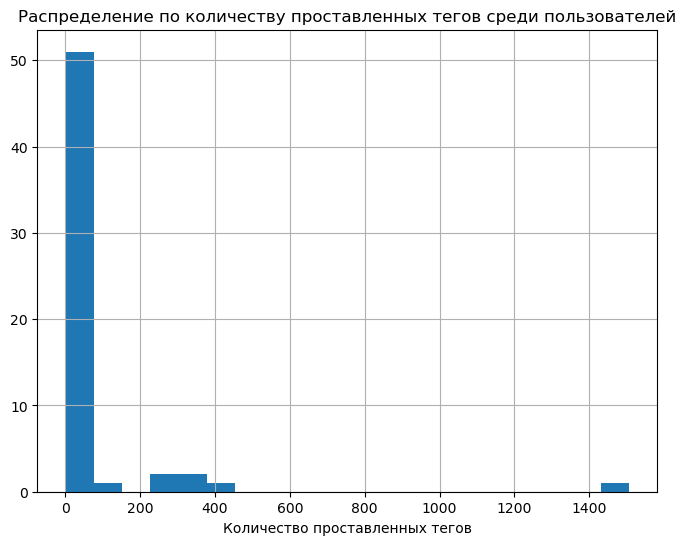

In [10]:
plt.figure(figsize=[8,6])
grouped_users.hist(bins=20)
plt.title('Распределение по количеству проставленных тегов среди пользователей')
plt.xlabel('Число пользователей')
plt.xlabel('Количество проставленных тегов')
plt.show()

**Фильмы**

In [11]:
grouped_movies = tags['movieId'].value_counts()

In [12]:
print(f'Уникальных фильмов в датасете: {len(grouped_movies)}')

Уникальных фильмов в датасете: 1572


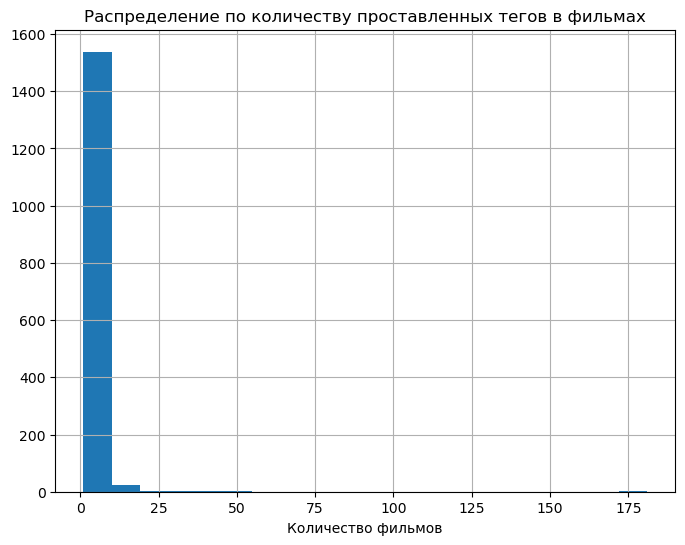

In [13]:
plt.figure(figsize=[8,6])
grouped_movies.hist(bins=20)
plt.title('Распределение по количеству проставленных тегов в фильмах')
plt.xlabel('Число тегов')
plt.xlabel('Количество фильмов')
plt.show()

### Произведём преобразование данных в вектора (TF-IDF) для жанров и тегов

In [14]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [15]:
movie_genres = [change_string(value) for value in movies.genres.values]

In [16]:
tfidf = TfidfVectorizer()
movie_train_tfidf = tfidf.fit_transform(movie_genres)
movie_train_tfidf = pd.DataFrame(movie_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [17]:
movies = movies.drop(columns=['genres', 'title'])
movies = pd.concat([movies, movie_train_tfidf], axis=1)

In [18]:
movies.head()

,movieId,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,4,0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,5,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [19]:
tag_strings = []
new_movies = []

for movie, group in tqdm(tags.groupby('movieId')):
    tag_strings.append(' '.join(set([change_string(str(s)) for s in group.tag.values])))
    new_movies.append(movie)

  0%|          | 0/1572 [00:00<?, ?it/s]

Добавим set, чтобы у нас остались только уникальные теги

In [20]:
tfidf_tag = TfidfVectorizer()
tag_train_tfidf = tfidf_tag.fit_transform(tag_strings)
tag_train_tfidf = pd.DataFrame(tag_train_tfidf.toarray(), columns=tfidf_tag.get_feature_names_out())

In [21]:
new_tags = pd.concat([pd.DataFrame(new_movies, columns=['movieId']), tag_train_tfidf], axis=1)
new_tags.head()

,movieId,06oscarnominatedbestmovieanimation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001like,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
movies_with_tags = movies.merge(new_tags, on='movieId')
movies_with_tags.dropna(inplace=True)
movies_with_tags.head()

,movieId,action_x,adventure_x,animation_x,children_x,comedy_x,crime_x,documentary_x,drama_x,fantasy_x,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.482990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.0,0.593662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Добавим в датасет новые признаки:
- среднюю оценку фильма
- среднюю оценку пользователя

In [23]:
movies_with_ratings = movies_with_tags.merge(ratings, on='movieId').drop(columns=['timestamp'])
movies_with_ratings.head()

,movieId,action_x,adventure_x,animation_x,children_x,comedy_x,crime_x,documentary_x,drama_x,fantasy_x,...,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,userId,rating
0,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0
1,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0
2,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5
3,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5
4,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5


In [24]:
mean_movie_rating = movies_with_ratings.groupby('movieId')['rating'].mean()
mean_user_rating = movies_with_ratings.groupby('userId')['rating'].mean()

In [57]:
movies_with_ratings['mean_movie_rating'] = movies_with_ratings['movieId'].apply(lambda x: mean_movie_rating[x])

In [58]:
movies_with_ratings['mean_user_rating'] = movies_with_ratings['userId'].apply(lambda x: mean_user_rating[x])

In [59]:
movies_with_ratings.head()

,movieId,action_x,adventure_x,animation_x,children_x,comedy_x,crime_x,documentary_x,drama_x,fantasy_x,...,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,userId,rating,mean_movie_rating,mean_user_rating
0,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,3.92093,4.403509
1,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0,3.92093,3.743590
2,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5,3.92093,3.543956
3,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5,3.92093,3.562500
4,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5,3.92093,4.279070


### Обучение модели с TF-IDF

In [71]:
X = movies_with_ratings.drop(columns=['rating'])
y = movies_with_ratings['rating']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [73]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [74]:
pred = model.predict(X_test)

In [75]:
np.sqrt(mean_squared_error(y_test, pred))

24909.614469306718

### Обучение модели без TF-IDF

In [77]:
X = movies_with_ratings[['movieId', 'userId', 'mean_movie_rating', 'mean_user_rating']]
y = movies_with_ratings['rating']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [79]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [80]:
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

0.7961733250369376

In [83]:
model.score(X_test, y_test)

0.31362508744775486

## Для проверяющего:
Добрый день.

Прошу подсказать, где у меня ошибка: вроде всё делал по заданию, но RMSE при обучении модели с TF-IDF составляет 24909.61.
Без TF-IDF же RMSE составило 0.7961, но при очень низкой точности 0.31